In [1]:
from osgeo import gdal
import numpy as np
import cv2
import tensorflow
import matplotlib.pyplot as plt
import glob
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout,Conv2DTranspose,ReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:

def raster2img(img_data):
    bands_count= img_data.RasterCount
    img = np.zeros([64,64,bands_count])
    out_img = np.zeros_like(img).astype(np.float32)
    for i in range(bands_count):
        dt = img_data.GetRasterBand(1)
        img[:,:,i] = dt.ReadAsArray(0,0,img_data.RasterXSize,img_data.RasterYSize)

        a,b = 0,1
        c = np.percentile(img[:,:,i],2)
        d = np.percentile(img[:,:,i],98)
        t = a+(img[:,:,i]-c)*(b-a)/(d-c)
        t[t<a] = a
        t[t>b] = b

        out_img[:,:,i] = t
        
    return out_img


In [3]:
def images_split(total_images_path):
    total_images = []
    for file in glob.iglob(total_images_path+'**/*.tif',recursive=True):
        image = gdal.Open(file, gdal.GA_ReadOnly)
        output_image = raster2img(image)
        total_images.append(output_image)
    
    total_images_count = len(total_images)
    total_images = np.asarray(total_images)
    n_train = 4506
    n_valid = 1100
    n_test = 80
    X_train = []
    X_valid = []
    X_test = []

    for i in range(0,n_train):
        X_train.append(total_images[i])

    for i in range(n_train,n_train+n_valid):
        X_valid.append(total_images[i])

    for i in range(n_train+n_valid,len(total_images)):
        X_test.append(total_images[i])
    
    X_train = np.asarray(X_train)
    X_valid = np.asarray(X_valid)
    X_test = np.asarray(X_test)

    return X_train,X_valid,X_test

In [4]:
total_images_path = 'D:/vision_impulse/images/'
X_train, X_valid, X_test = images_split(total_images_path)

In [5]:
def raster2label(img_data):
    bands_count = img_data.RasterCount
    if bands_count ==1:
        gray = img_data.GetRasterBand(1)

        gray1 = gray.ReadAsArray()

        label = np.asarray(gray1)
    
    return label

In [6]:
def labels_split(total_labels_path):
    total_labels = []
    for file in glob.iglob(total_labels_path+'**/*.tif',recursive=True):
        label = gdal.Open(file, gdal.GA_ReadOnly)
        output_label = raster2label(label)
        total_labels.append(output_label)
    
    total_label_count = len(total_labels)
    total_labels = np.asarray(total_labels)
    n_train = 4506
    n_valid = 1100
    n_test = 80
    y_train = []
    y_valid = []
    y_test = []

    for i in range(0,n_train):
        y_train.append(total_labels[i])

    for i in range(n_train,n_train+n_valid):
        y_valid.append(total_labels[i])

    for i in range(n_train+n_valid,len(total_labels)):
        y_test.append(total_labels[i])
    
    y_train = np.asarray(y_train)
    y_valid = np.asarray(y_valid)
    y_test = np.asarray(y_test)

    return y_train,y_valid,y_test

In [7]:
total_labels_path = 'D:/vision_impulse/labels/'
y_train,y_valid,y_test = labels_split(total_labels_path)

In [10]:
assert X_train.shape[0] == y_train.shape[0]
print(f'Train images and labels are of same length : {X_train.shape[0]}')

Train images and labels are of same length : 4506


In [17]:
def conv_block(input_tensor, num_filters,kernel_size):
    c = Conv2D(filters= num_filters,kernel_size=kernel_size,kernel_initializer='he_normal',strides=(1,1),padding='same')(input_tensor)
    c = ReLU()(c)
    return c


In [18]:
def U_Net(input_lr,num_filters=64,kernel_size=3,dropout_rate=0.1):
    
    #block1
    c1 = conv_block(input_lr,num_filters*1,kernel_size=kernel_size)
    c2 = conv_block(c1,num_filters*1,kernel_size=kernel_size)
    p1 = MaxPooling2D(pool_size=(2,2))(c2)
    
    #block2
    c3 = conv_block(p1,num_filters*2,kernel_size=kernel_size)
    c4 = conv_block(c3,num_filters*2,kernel_size=kernel_size)
    p2 = MaxPooling2D(pool_size=(2,2))(c4)
    
    #block3
    c5 = conv_block(p2,num_filters*4,kernel_size=kernel_size)
    c5 = Dropout(dropout_rate)(c5)
    c6 = conv_block(c5,num_filters*4,kernel_size=kernel_size)
    p3 = MaxPooling2D(pool_size=(2,2))(c6)
    
    #block4
    c7 = conv_block(p3,num_filters*8,kernel_size=kernel_size)
    c7 = Dropout(dropout_rate)(c7)
    c8 = conv_block(c7,num_filters*8,kernel_size=kernel_size)
    p4 = MaxPooling2D(pool_size=(2,2))(c8)
    
    #block5(bottleneck)
    c9 = conv_block(p4,num_filters*16,kernel_size = kernel_size)
    c10 = conv_block(c9,num_filters*16,kernel_size=kernel_size)
    
    #expanding block (block6)
    u6 = Conv2DTranspose(filters=num_filters*8,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c10)
    u6 = concatenate([u6,c8])
    c11 = conv_block(u6,num_filters*8,kernel_size=kernel_size)
    c11 = Dropout(dropout_rate)(c11)
    c12 = conv_block(c11,num_filters*8,kernel_size=kernel_size)
    
    #block7
    u7 = Conv2DTranspose(filters=num_filters*4,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c12)
    u7 = concatenate([u7,c6])
    c13 = conv_block(u7,num_filters*4,kernel_size=kernel_size)
    c13 = Dropout(dropout_rate)(c13)
    c14 = conv_block(c13,num_filters*4,kernel_size=kernel_size)
    
    #block8
    u8 = Conv2DTranspose(filters=num_filters*2,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c14)
    u8 = concatenate([u8,c4])
    c15 = conv_block(u8,num_filters*2,kernel_size=kernel_size)
    c15 = Dropout(dropout_rate)(c15)
    c16 = conv_block(c15,num_filters*2,kernel_size=kernel_size)
    
    #block9
    u9 = Conv2DTranspose(filters= num_filters*1,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c16)
    u9 = concatenate([u9,c2])
    c17 = conv_block(u9,num_filters*1,kernel_size=kernel_size)
    c18 = conv_block(c17,num_filters*1,kernel_size=kernel_size)
    
    output = Conv2D(filters=1,kernel_size=(1,1),strides=(1,1),padding='same',activation='sigmoid',kernel_initializer='he_normal')(c18)
    
    model = Model(inputs=[input_lr],outputs=[output])
    
    return model

In [19]:
input_lr = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name='input_lr')
model = U_Net(input_lr)
model.compile(optimizer=Adam(1e-4),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lr (InputLayer)           [(None, 64, 64, 12)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   6976        input_lr[0][0]                   
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       re_lu[0][0]                      
______________________________________________________________________________________________

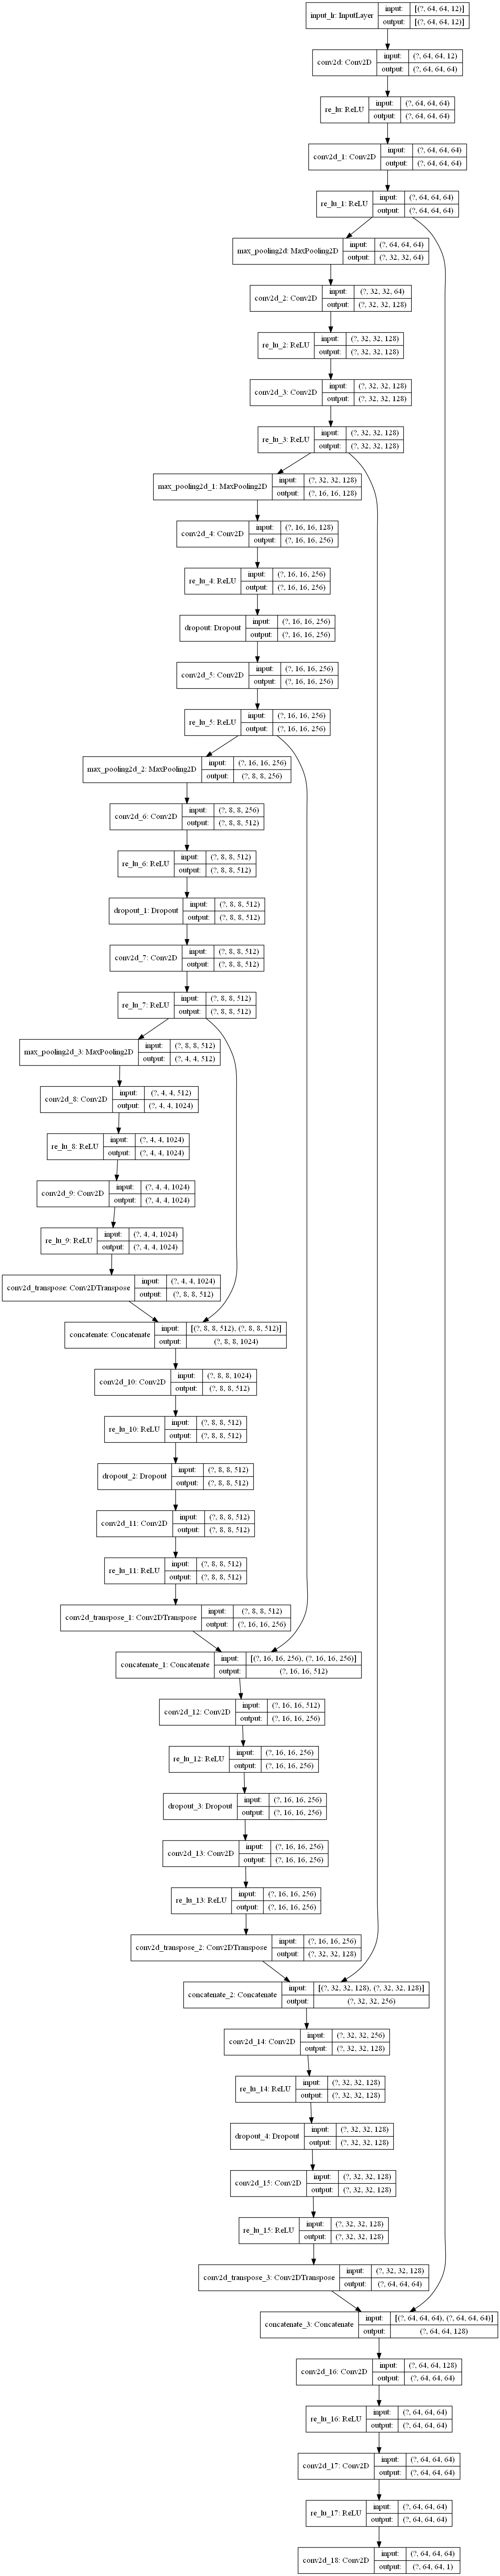

In [20]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [21]:
weights_path = 'D:/vision_impulse/weights/multispectral/'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
file_path = os.path.join(weights_path+'model/')
print(file_path)


D:/vision_impulse/weights/multispectral/model/


In [22]:
es = EarlyStopping(patience=5,monitor='val_loss',mode ='auto',restore_best_weights=True)
mc = ModelCheckpoint(filepath = file_path,monitor='val_loss',save_best_only=True)


In [23]:

batch_size = 8
steps_per_epoch = int(X_train.shape[0])//batch_size
epochs = 30

In [24]:
history = model.fit(X_train,y_train, epochs=epochs,steps_per_epoch= steps_per_epoch, validation_data =(X_valid, y_valid),callbacks = [es,mc] )


Epoch 1/30
563/563 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.6468WARNING:tensorflow:From C:\Users\Dheeraj Reddy P\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:/vision_impulse/weights/multispectral/model/assets
563/563 [==============================] - 289s 513ms/step - loss: 0.2299 - accuracy: 0.6468 - val_loss: 0.8767 - val_accuracy: 0.5243
Epoch 2/30
563/563 [==============================] - 191s 340ms/step - loss: -0.0838 - accuracy: 0.6741 - val_loss: 0.7009 - val_accuracy: 0.5610
Epoch 3/30
563/563 [==============================] - 192s 340ms/step - loss: -0.2773 - accuracy: 0.6845 - val_loss: 0.3599 - val_accuracy: 0.5880
E

In [25]:
model.save('D:/vision_impulse/weights/multispectral_model.h5')


In [26]:
y_pred =model.predict(X_test)


In [28]:

def visualize_labels(viz_list):
    plt.figure(figsize=(15,15))
    title = ['Input_mask', 'predicted_mask']
    
    for i in range(len(viz_list)):
        plt.subplot(1,len(viz_list), i+1)
        plt.title(title[i])
        plt.imshow(viz_list[i])
        plt.axis('off')
    plt.show()

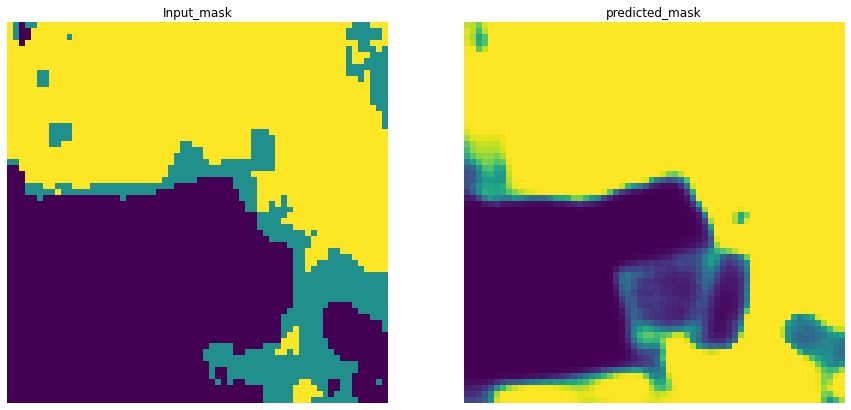

In [29]:
visualize_labels([y_test[0],y_pred[0]])

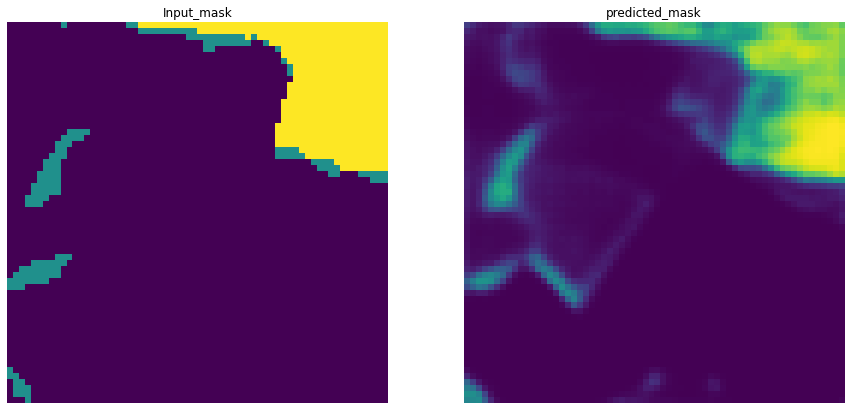

In [34]:
visualize_labels([y_test[15],y_pred[15]])